In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Jan  5 13:51:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   35C    P0    32W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import ThreeFeature_All_CNN6Layer_A as ModelA
from model.models_mjp_19November20 import ThreeFeature_All_CNN6Layer_A1 as ModelA1
from model.models_mjp_19November20 import ThreeFeature_All_CNN6Layer_E as ModelE
from model.models_mjp_19November20 import ThreeFeature_All_CNN8Layer_W as ModelW
from model.models_mjp_26December20 import ThreeFeature_All_CNN10Layer_X as ModelX

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 40, 5e-5, 3920)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
## 
                            #device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=True,
                            load_xy=True)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          #device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=True,
                          load_xy=True)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 19.29 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 19.03 s
Constructing 160000 event dataset took 0.7377 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 4.714 s
Constructing 9984 event dataset took 0.04759 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelX()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=5.0)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/af85e546561c4927aa730fbb2b31f529/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict, freeze_weights=False)

we also froze 0 weights
Of the 37.5 parameter layers to update in the current model, 37.5 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

ThreeFeature_All_CNN10Layer_X(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFinalFilter): Conv1d(1, 1

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


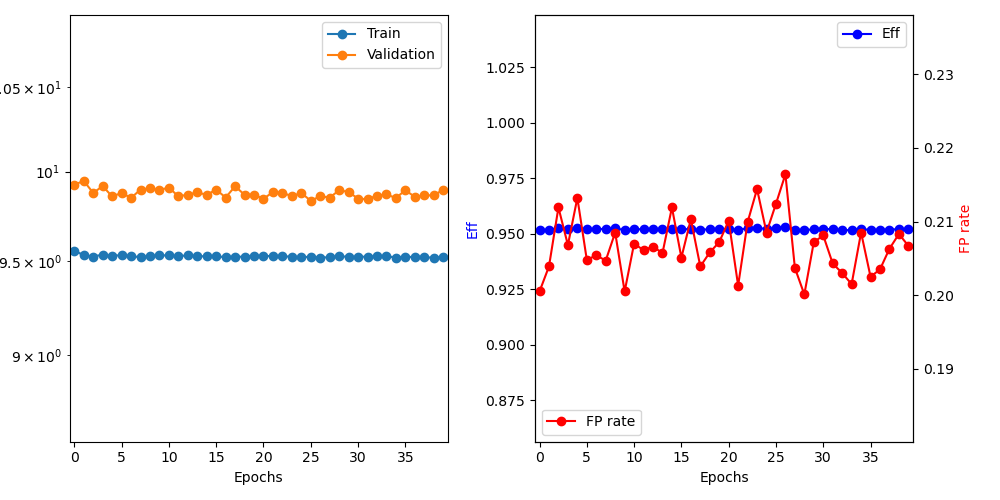

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  ThreeFeature_All_CNN10Layer_X(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(20, 7, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv8): Conv1d(7, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(10, 1, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppFinalFilter):

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 3920: train=9.55652, val=9.92606, took 93.737 s
  Validation Found 51867 of 54504, added 2002 (eff 95.16%) (0.201 FP/event)
Result epoch:  3920
Average Eff:  0
Average FP Rate:  0


Epoch 3921: train=9.53163, val=9.94691, took 87.776 s
  Validation Found 51867 of 54504, added 2036 (eff 95.16%) (0.204 FP/event)
Result epoch:  3921
Average Eff:  0
Average FP Rate:  0


Epoch 3922: train=9.52443, val=9.87877, took 87.162 s
  Validation Found 51908 of 54504, added 2116 (eff 95.24%) (0.212 FP/event)
Result epoch:  3922
Average Eff:  0
Average FP Rate:  0


Epoch 3923: train=9.53475, val=9.91772, took 87.35 s
  Validation Found 51888 of 54504, added 2065 (eff 95.20%) (0.207 FP/event)
Result epoch:  3923
Average Eff:  0
Average FP Rate:  0


Epoch 3924: train=9.52676, val=9.85854, took 87.445 s
  Validation Found 51925 of 54504, added 2129 (eff 95.27%) (0.213 FP/event)
Result epoch:  3924
Average Eff:  0
Average FP Rate:  0


Epoch 3925: train=9.53312, val=9.87893, took 87.632 s
  Validation Found 51881 of 54504, added 2045 (eff 95.19%) (0.205 FP/event)
Result epoch:  3925
Average Eff:  0
Average FP Rate:  0


Epoch 3926: train=9.52639, val=9.85043, took 89.726 s
  Validation Found 51885 of 54504, added 2051 (eff 95.19%) (0.205 FP/event)
Result epoch:  3926
Average Eff:  0
Average FP Rate:  0


Epoch 3927: train=9.52078, val=9.89795, took 91.263 s
  Validation Found 51899 of 54504, added 2044 (eff 95.22%) (0.205 FP/event)
Result epoch:  3927
Average Eff:  0
Average FP Rate:  0


Epoch 3928: train=9.52677, val=9.9049, took 87.863 s
  Validation Found 51908 of 54504, added 2082 (eff 95.24%) (0.209 FP/event)
Result epoch:  3928
Average Eff:  0
Average FP Rate:  0


Epoch 3929: train=9.53097, val=9.89515, took 87.925 s
  Validation Found 51866 of 54504, added 2002 (eff 95.16%) (0.201 FP/event)
Result epoch:  3929
Average Eff:  0
Average FP Rate:  0


Epoch 3930: train=9.5305, val=9.90952, took 87.292 s
  Validation Found 51883 of 54504, added 2067 (eff 95.19%) (0.207 FP/event)
Result epoch:  3930
Average Eff:  0
Average FP Rate:  0


Epoch 3931: train=9.52602, val=9.85925, took 87.256 s
  Validation Found 51888 of 54504, added 2058 (eff 95.20%) (0.206 FP/event)
Result epoch:  3931
Average Eff:  0
Average FP Rate:  0


Epoch 3932: train=9.5313, val=9.869, took 87.578 s
  Validation Found 51891 of 54504, added 2063 (eff 95.21%) (0.207 FP/event)
Result epoch:  3932
Average Eff:  0
Average FP Rate:  0


Epoch 3933: train=9.52515, val=9.8821, took 87.39 s
  Validation Found 51882 of 54504, added 2054 (eff 95.19%) (0.206 FP/event)
Result epoch:  3933
Average Eff:  0
Average FP Rate:  0


Epoch 3934: train=9.52625, val=9.86786, took 87.361 s
  Validation Found 51900 of 54504, added 2116 (eff 95.22%) (0.212 FP/event)
Result epoch:  3934
Average Eff:  0
Average FP Rate:  0


Epoch 3935: train=9.52662, val=9.89788, took 87.522 s
  Validation Found 51882 of 54504, added 2048 (eff 95.19%) (0.205 FP/event)
Result epoch:  3935
Average Eff:  0
Average FP Rate:  0


Epoch 3936: train=9.52015, val=9.85241, took 87.355 s
  Validation Found 51893 of 54504, added 2100 (eff 95.21%) (0.21 FP/event)
Result epoch:  3936
Average Eff:  0
Average FP Rate:  0


Epoch 3937: train=9.52425, val=9.91676, took 87.271 s
  Validation Found 51866 of 54504, added 2036 (eff 95.16%) (0.204 FP/event)
Result epoch:  3937
Average Eff:  0
Average FP Rate:  0


Epoch 3938: train=9.52276, val=9.86816, took 87.283 s
  Validation Found 51892 of 54504, added 2055 (eff 95.21%) (0.206 FP/event)
Result epoch:  3938
Average Eff:  0
Average FP Rate:  0


Epoch 3939: train=9.52872, val=9.86915, took 87.352 s
  Validation Found 51894 of 54504, added 2069 (eff 95.21%) (0.207 FP/event)
Result epoch:  3939
Average Eff:  0
Average FP Rate:  0


Epoch 3940: train=9.52856, val=9.84568, took 87.199 s
  Validation Found 51889 of 54504, added 2098 (eff 95.20%) (0.21 FP/event)
Result epoch:  3940
Average Eff:  0
Average FP Rate:  0


Epoch 3941: train=9.52606, val=9.88353, took 87.388 s
  Validation Found 51872 of 54504, added 2010 (eff 95.17%) (0.201 FP/event)
Result epoch:  3941
Average Eff:  0
Average FP Rate:  0


Epoch 3942: train=9.52862, val=9.87961, took 87.105 s
  Validation Found 51910 of 54504, added 2096 (eff 95.24%) (0.21 FP/event)
Result epoch:  3942
Average Eff:  0
Average FP Rate:  0


Epoch 3943: train=9.52131, val=9.8603, took 87.337 s
  Validation Found 51921 of 54504, added 2141 (eff 95.26%) (0.214 FP/event)
Result epoch:  3943
Average Eff:  0
Average FP Rate:  0


Epoch 3944: train=9.52046, val=9.87876, took 87.311 s
  Validation Found 51892 of 54504, added 2082 (eff 95.21%) (0.209 FP/event)
Result epoch:  3944
Average Eff:  0
Average FP Rate:  0


Epoch 3945: train=9.52367, val=9.83409, took 87.292 s
  Validation Found 51914 of 54504, added 2121 (eff 95.25%) (0.212 FP/event)
Result epoch:  3945
Average Eff:  0
Average FP Rate:  0


Epoch 3946: train=9.51738, val=9.86004, took 87.247 s
  Validation Found 51949 of 54504, added 2161 (eff 95.31%) (0.216 FP/event)
Result epoch:  3946
Average Eff:  0
Average FP Rate:  0


Epoch 3947: train=9.52163, val=9.85261, took 87.232 s
  Validation Found 51875 of 54504, added 2034 (eff 95.18%) (0.204 FP/event)
Result epoch:  3947
Average Eff:  0
Average FP Rate:  0


Epoch 3948: train=9.5259, val=9.89373, took 87.166 s
  Validation Found 51857 of 54504, added 1998 (eff 95.14%) (0.2 FP/event)
Result epoch:  3948
Average Eff:  0
Average FP Rate:  0


Epoch 3949: train=9.52283, val=9.88458, took 87.468 s
  Validation Found 51891 of 54504, added 2069 (eff 95.21%) (0.207 FP/event)
Result epoch:  3949
Average Eff:  0
Average FP Rate:  0


Epoch 3950: train=9.52257, val=9.84643, took 87.304 s
  Validation Found 51902 of 54504, added 2078 (eff 95.23%) (0.208 FP/event)
Result epoch:  3950
Average Eff:  0.9522603845589315
Average FP Rate:  0.20811216825237858


Epoch 3951: train=9.52403, val=9.84336, took 87.28 s
  Validation Found 51880 of 54504, added 2040 (eff 95.19%) (0.204 FP/event)
Result epoch:  3951
Average Eff:  1.9041171290180539
Average FP Rate:  0.41241862794191286


Epoch 3952: train=9.52548, val=9.86345, took 87.193 s
  Validation Found 51868 of 54504, added 2027 (eff 95.16%) (0.203 FP/event)
Result epoch:  3952
Average Eff:  2.8557537061500073
Average FP Rate:  0.6154231347020531


Epoch 3953: train=9.52829, val=9.87065, took 87.295 s
  Validation Found 51862 of 54504, added 2012 (eff 95.15%) (0.202 FP/event)
Result epoch:  3953
Average Eff:  3.8072801996183765
Average FP Rate:  0.8169253880821232


Epoch 3954: train=9.51721, val=9.84981, took 87.251 s
  Validation Found 51904 of 54504, added 2082 (eff 95.23%) (0.209 FP/event)
Result epoch:  3954
Average Eff:  4.759577278731836
Average FP Rate:  1.0254381572358537


Epoch 3955: train=9.5239, val=9.89428, took 87.258 s
  Validation Found 51860 of 54504, added 2022 (eff 95.15%) (0.203 FP/event)
Result epoch:  3955
Average Eff:  5.711067077645677
Average FP Rate:  1.2279419128693039


Epoch 3956: train=9.52096, val=9.85654, took 87.626 s
  Validation Found 51877 of 54504, added 2032 (eff 95.18%) (0.204 FP/event)
Result epoch:  3956
Average Eff:  6.6628687802730076
Average FP Rate:  1.431447170756134


Epoch 3957: train=9.52444, val=9.86493, took 87.877 s
  Validation Found 51870 of 54504, added 2060 (eff 95.17%) (0.206 FP/event)
Result epoch:  3957
Average Eff:  7.614542051959489
Average FP Rate:  1.6377566349524284


Epoch 3958: train=9.51498, val=9.86503, took 87.851 s
  Validation Found 51895 of 54504, added 2080 (eff 95.21%) (0.208 FP/event)
Result epoch:  3958
Average Eff:  8.566674005577573
Average FP Rate:  1.846069103655483


Epoch 3959: train=9.52452, val=9.8967, took 87.832 s
  Validation Found 51882 of 54504, added 2064 (eff 95.19%) (0.207 FP/event)
Result epoch:  3959
Averaging...

Average Eff:  0.9518567444591224
Average FP Rate:  0.20527791687531294



<IPython.core.display.Javascript object>


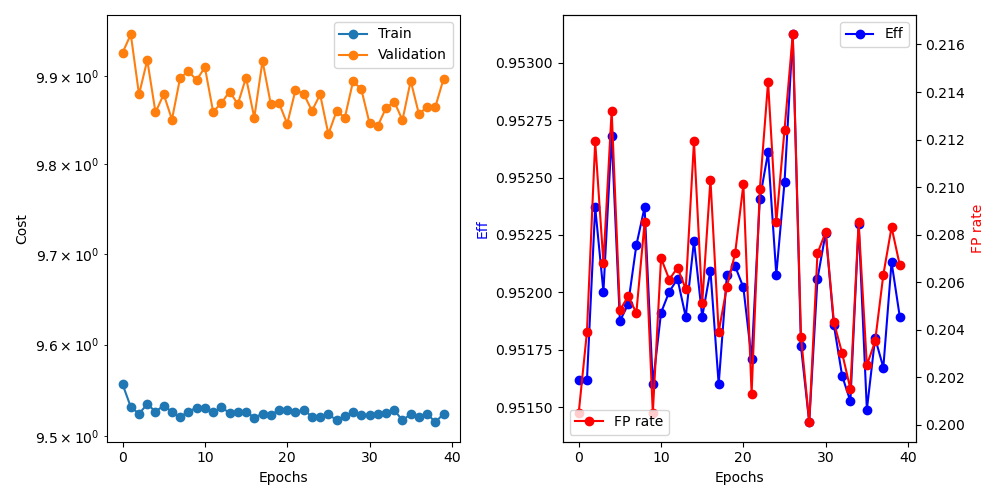

In [12]:
avgEff=0
avgFP=0
print('for model: ', model)   
run_name = 'Model X (PA)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '5.0')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

In [13]:
##quit()